In [1]:
import os
import pandas as pd
import numpy as np 
from re import search

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings("ignore")

<h3>Importing the dataset</h3>

In [4]:
cwd = os.getcwd()
dataset_dir = os.path.join(cwd,'Dataset')
result_dir = os.path.join(cwd,'Results')

In [5]:
modelname = ['GBC','LR','MNB','RFC','SVM']
modelnamebase = ['GBC','LR','MNB','RFC','SVM']

In [6]:
test_res = []
train_res = []
valid_res = []

In [7]:
base_test_res = []
base_train_res = []
base_valid_res = []

<h3>Result Processing</h3>

<h4>Base</h4>

In [8]:
for model in modelnamebase:
    base_train_df = pd.read_csv(os.path.join(result_dir, f'BASE\BASE_{model}_Train_result.csv'))
    base_test_df = pd.read_csv(os.path.join(result_dir, f'BASE\BASE_{model}_Test_result.csv'))
    
    unnamed_columns = [col for col in base_test_df.columns if search(r'^Unnamed', col)]
    base_test_df = base_test_df.drop(unnamed_columns, axis=1)
    base_test_df.drop('Time (Sec)', axis=1, inplace=True)
    
    unnamed_columns = [col for col in base_train_df.columns if search(r'^Unnamed', col)]
    base_train_df = base_train_df.drop(unnamed_columns, axis=1)
    base_train_df.drop('Time (Sec)', axis=1, inplace=True)
    
    base_test_df.drop('ID', axis=1, inplace=True)
    base_train_df.drop('ID', axis=1, inplace=True)
    
    base_final_test_res = base_test_df.to_dict(orient='records')[0]
    base_final_test_res['Model'] = model
    base_test_res.append(base_final_test_res)
    
    base_final_train_res = base_train_df.to_dict(orient='records')[0]
    base_final_train_res['Model'] = model
    base_train_res.append(base_final_train_res)

In [9]:
model = 'Voting'
base_train_df = pd.read_csv(os.path.join(result_dir, f'BASE\BASE_{model}_Train_result.csv'))
base_test_df = pd.read_csv(os.path.join(result_dir, f'BASE\BASE_{model}_Test_result.csv'))

unnamed_columns = [col for col in base_test_df.columns if search(r'^Unnamed', col)]
base_test_df = base_test_df.drop(unnamed_columns, axis=1)
base_test_df.drop('Time (Sec)', axis=1, inplace=True)

unnamed_columns = [col for col in base_train_df.columns if search(r'^Unnamed', col)]
base_train_df = base_train_df.drop(unnamed_columns, axis=1)
base_train_df.drop('Time (Sec)', axis=1, inplace=True)

base_final_test_res = base_test_df.to_dict(orient='records')[0]
base_final_test_res['Model'] = model
base_test_res.append(base_final_test_res)

base_final_train_res = base_train_df.to_dict(orient='records')[0]
base_final_train_res['Model'] = model
base_train_res.append(base_final_train_res)

In [10]:
modelnamebase.append('Voting')

In [11]:
for model in modelnamebase :
    file_path = os.path.join(result_dir,f'BASE\BASE_{model}_Valid_report.txt')

    with open(file_path, 'r') as file:
        classification_report_str = file.read()

    lines = classification_report_str.strip().split('\n')

    accuracy_line = lines[-3].split()[1:]
    macro_avg_line = lines[-2].split()[2:-1]

    accuracy = float(accuracy_line[0])
    macro_avg_precision, macro_avg_recall, macro_avg_f1 = map(float, macro_avg_line)
    
    base_valid_res_mdl = dict()
    base_valid_res_mdl['Accuracy'] = accuracy
    base_valid_res_mdl['F1-Score'] = macro_avg_f1
    base_valid_res_mdl['Recall'] = macro_avg_recall
    base_valid_res_mdl['Precision'] = macro_avg_precision
    base_valid_res_mdl['Model']=model
    
    base_valid_res.append(base_valid_res_mdl)

In [12]:
base_test_res_df = pd.DataFrame(base_test_res)
base_test_res_df['Model'] = base_test_res_df['Model'].astype(str)
base_test_res_df.head(6)

,Accuracy,F1-Score,Recall,Precision,Model
0,0.881575,0.885205,0.906671,0.864908,GBC
1,0.898288,0.902370,0.933276,0.873587,LR
2,0.770578,0.708293,0.555462,0.981306,MNB
3,0.867960,0.869902,0.876380,0.863677,RFC
4,0.912729,0.916454,0.949651,0.885631,SVM
5,0.907778,0.911288,0.940236,0.884182,Voting


In [13]:
base_train_res_df = pd.DataFrame(base_train_res)
base_train_res_df['Model'] = base_train_res_df['Model'].astype(str)
base_train_res_df.head(6)

,Accuracy,F1-Score,Recall,Precision,Model
0,0.944502,0.946092,0.966230,0.926780,GBC
1,0.941613,0.943122,0.960397,0.926461,LR
2,0.852383,0.828945,0.709680,0.996409,MNB
3,1.000000,1.000000,1.000000,1.000000,RFC
4,0.994430,0.994480,0.995497,0.993465,SVM
5,0.988756,0.988804,0.985161,0.992474,Voting


In [14]:
base_valid_res_df = pd.DataFrame(base_valid_res)
base_valid_res_df['Model'] = base_valid_res_df['Model'].astype(str)
base_valid_res_df.head(6)

,Accuracy,F1-Score,Recall,Precision,Model
0,0.89191,0.89156,0.89101,0.89301,GBC
1,0.90099,0.90070,0.90018,0.90192,LR
2,0.78300,0.77635,0.78993,0.83831,MNB
3,0.86716,0.86709,0.86737,0.86700,RFC
4,0.92739,0.92715,0.92650,0.92880,SVM
5,0.91832,0.91810,0.91762,0.91913,Voting


<h4>Hyper Tuned</h4>

In [15]:
for model in modelname :
    train_df = pd.read_csv(os.path.join(result_dir,f'{model}_Train_result.csv'))
    test_df = pd.read_csv(os.path.join(result_dir,f'{model}_Test_result.csv'))
    parameter_df = pd.read_csv(os.path.join(result_dir,f'{model}_Parameters.csv'))
    
    unnamed_columns = [col for col in test_df.columns if search(r'^Unnamed', col)]
    test_df = test_df.drop(unnamed_columns, axis=1)
    test_columns = list(test_df.columns)
    
    test_top_ten = pd.DataFrame()
    test_top_ten = test_top_ten.append(test_df.nlargest(1, ['Accuracy']), ignore_index = True)
    test_top_ten.columns = test_columns
    test_top_ten.drop('Time (Sec)', axis=1, inplace=True)
    
    print('Test')
    print(test_top_ten)
    
    ID_list = list(test_top_ten['ID'])
    
    unnamed_columns = [col for col in train_df.columns if search(r'^Unnamed', col)]
    train_df = train_df.drop(unnamed_columns, axis=1)
    train_columns = list(train_df.columns)
    
    train_ten = pd.DataFrame()
    for ID in ID_list :
        train_ten = train_ten.append([train_df[train_df.ID == ID]], ignore_index = True)
    train_ten.columns = train_columns
    train_ten.drop('Time (Sec)', axis=1, inplace=True)
    '''
    print('Train')
    print(train_ten)
    '''
    unnamed_columns = [col for col in parameter_df.columns if search(r'^Unnamed', col)]
    parameter_df = parameter_df.drop(unnamed_columns, axis=1)
    parameter_columns = list(parameter_df.columns)
    
    parameter_ten = pd.DataFrame()
    for ID in ID_list :
        parameter_ten = parameter_ten.append([parameter_df[parameter_df.ID == ID]], ignore_index = True)
    parameter_ten.columns = parameter_columns
    
    print(f'Parameters {model}')
    print(parameter_ten)
    print('\n')
    
    final_test_res = dict(test_top_ten.mean())
    final_test_res['Model'] = model
    test_res.append(final_test_res)
    
    final_train_res = dict(train_ten.mean())
    final_train_res['Model'] = model
    train_res.append(final_train_res)

Test
         ID  Accuracy  F1-Score    Recall  Precision
0  GBC-0051  0.923458  0.925039  0.937778   0.912766
Parameters GBC
   random_state  n_estimators  min_samples_split  min_samples_leaf  \
0          1973           350               92.0              21.0   

  max_features  max_depth  learning_rate     criterion        ID  
0         sqrt       54.0           0.08  friedman_mse  GBC-0051  


Test
        ID  Accuracy  F1-Score    Recall  Precision
0  LR-0096  0.923458  0.925371  0.941462   0.909952
Parameters LR
      solver  random_state penalty  max_iter      C       ID
0  liblinear          1973      l2      1000  79.35  LR-0096


Test
         ID  Accuracy  F1-Score   Recall  Precision
0  MNB-0051  0.899731  0.897471  0.87146    0.92527
Parameters MNB
   fit_prior  alpha        ID
0       True   0.02  MNB-0051


Test
         ID  Accuracy  F1-Score    Recall  Precision
0  RFC-0022  0.865073  0.869572  0.892752   0.847848
Parameters RFC
   random_state  n_estimators  min_sam

In [16]:
model = 'Voting'
train_df = pd.read_csv(os.path.join(result_dir,f'{model}_Train_result.csv'))
test_df = pd.read_csv(os.path.join(result_dir,f'{model}_Test_result.csv'))

unnamed_columns = [col for col in test_df.columns if search(r'^Unnamed', col)]
test_df = test_df.drop(unnamed_columns, axis=1)
test_columns = list(test_df.columns)

test_top_ten = pd.DataFrame()
test_top_ten = test_top_ten.append(test_df, ignore_index = True)
test_top_ten.columns = test_columns
test_top_ten.drop('Time (Sec)', axis=1, inplace=True)

print('Test')
print(test_top_ten)

unnamed_columns = [col for col in train_df.columns if search(r'^Unnamed', col)]
train_df = train_df.drop(unnamed_columns, axis=1)
train_columns = list(train_df.columns)

train_ten = pd.DataFrame()
train_ten = train_ten.append(train_df, ignore_index = True)
train_ten.columns = train_columns
train_ten.drop('Time (Sec)', axis=1, inplace=True)

print('Train')
print(train_ten)

final_test_res = dict(test_top_ten.mean())
final_test_res['Model'] = model
test_res.append(final_test_res)

final_train_res = dict(train_ten.mean())
final_train_res['Model'] = model
train_res.append(final_train_res)

Test
   Accuracy  F1-Score    Recall  Precision
0  0.928616  0.929797  0.938185   0.921745
Train
   Accuracy  F1-Score    Recall  Precision
0  0.999639  0.999642  0.999284        1.0


In [17]:
modelname.append('Voting')

In [18]:
for model in modelname :
    file_path = os.path.join(result_dir,f'{model}_Valid_report.txt')

    with open(file_path, 'r') as file:
        classification_report_str = file.read()

    lines = classification_report_str.strip().split('\n')

    accuracy_line = lines[-3].split()[1:]
    macro_avg_line = lines[-2].split()[2:-1]

    accuracy = float(accuracy_line[0])
    macro_avg_precision, macro_avg_recall, macro_avg_f1 = map(float, macro_avg_line)
    
    valid_res_mdl = dict()
    valid_res_mdl['Accuracy'] = accuracy
    valid_res_mdl['F1-Score'] = macro_avg_f1
    valid_res_mdl['Recall'] = macro_avg_recall
    valid_res_mdl['Precision'] = macro_avg_precision
    valid_res_mdl['Model']=model
    
    valid_res.append(valid_res_mdl)

In [19]:
test_res_df = pd.DataFrame(test_res)
test_res_df['Model'] = test_res_df['Model'].astype(str)
test_res_df.head(6)

,Accuracy,F1-Score,Recall,Precision,Model
0,0.923458,0.925039,0.937778,0.912766,GBC
1,0.923458,0.925371,0.941462,0.909952,LR
2,0.899731,0.897471,0.871460,0.925270,MNB
3,0.865073,0.869572,0.892752,0.847848,RFC
4,0.924284,0.925835,0.937780,0.914333,SVM
5,0.928616,0.929797,0.938185,0.921745,Voting


In [20]:
train_res_df = pd.DataFrame(train_res)
train_res_df['Model'] = train_res_df['Model'].astype(str)
train_res_df.head(6)

,Accuracy,F1-Score,Recall,Precision,Model
0,1.000000,1.000000,1.000000,1.000000,GBC
1,1.000000,1.000000,1.000000,1.000000,LR
2,0.980194,0.980112,0.968277,0.992244,MNB
3,0.951568,0.953351,0.981887,0.926428,RFC
4,0.999175,0.999181,0.999284,0.999079,SVM
5,0.999639,0.999642,0.999284,1.000000,Voting


In [21]:
valid_res_df = pd.DataFrame(valid_res)
valid_res_df['Model'] = valid_res_df['Model'].astype(str)
valid_res_df.head(6)

,Accuracy,F1-Score,Recall,Precision,Model
0,0.94224,0.94215,0.94195,0.94243,GBC
1,0.93399,0.93383,0.93340,0.93468,LR
2,0.91502,0.91502,0.91620,0.91636,MNB
3,0.85809,0.85782,0.85763,0.85814,RFC
4,0.93729,0.93718,0.93693,0.93755,SVM
5,0.94224,0.94215,0.94195,0.94243,Voting


<h3>Graphing</h3>

In [22]:
graph_dir = os.path.join(cwd,'Graphs')

<h3>Base</h3>

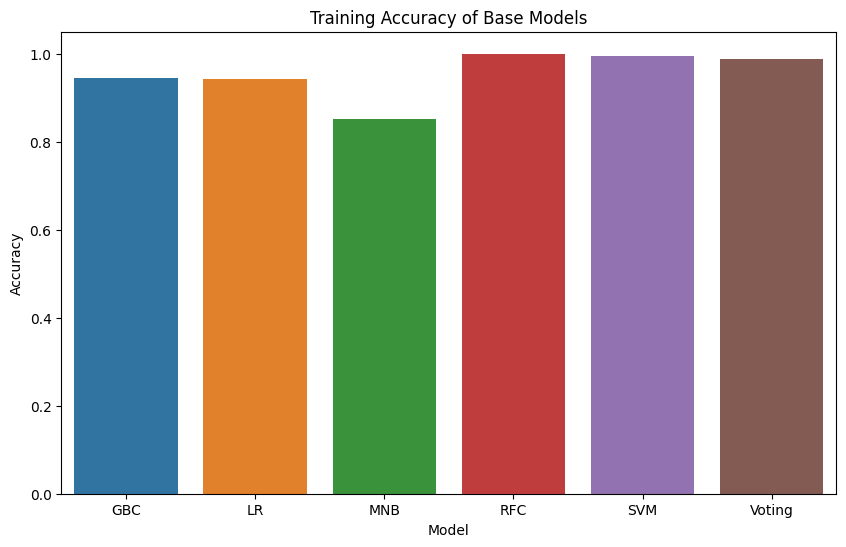

In [23]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=base_train_res_df)
title='Training Accuracy of Base Models'
plt.title(title)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.savefig(os.path.join(graph_dir,title+'.png'), bbox_inches='tight')
plt.show()
plt.close()

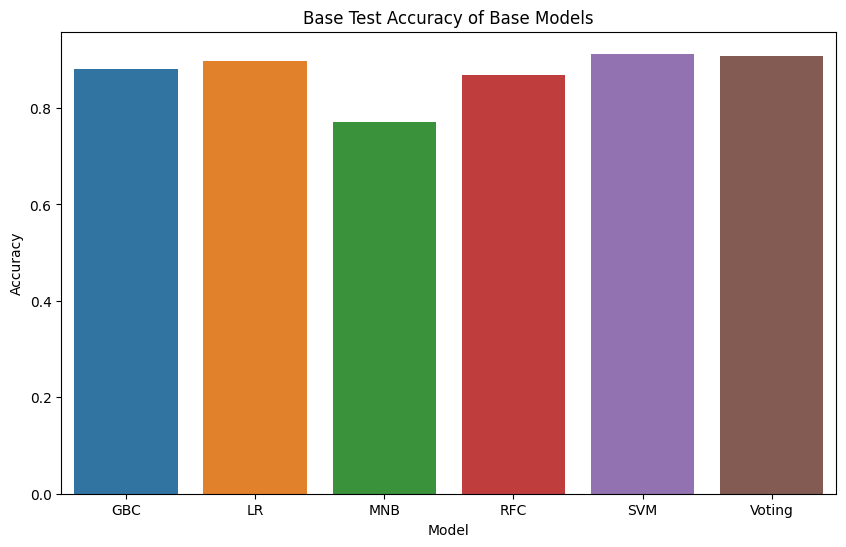

In [24]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=base_test_res_df)
title = 'Base Test Accuracy of Base Models'
plt.title(title)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.savefig(os.path.join(graph_dir,title+'.png'), bbox_inches='tight')
plt.show()
plt.close()

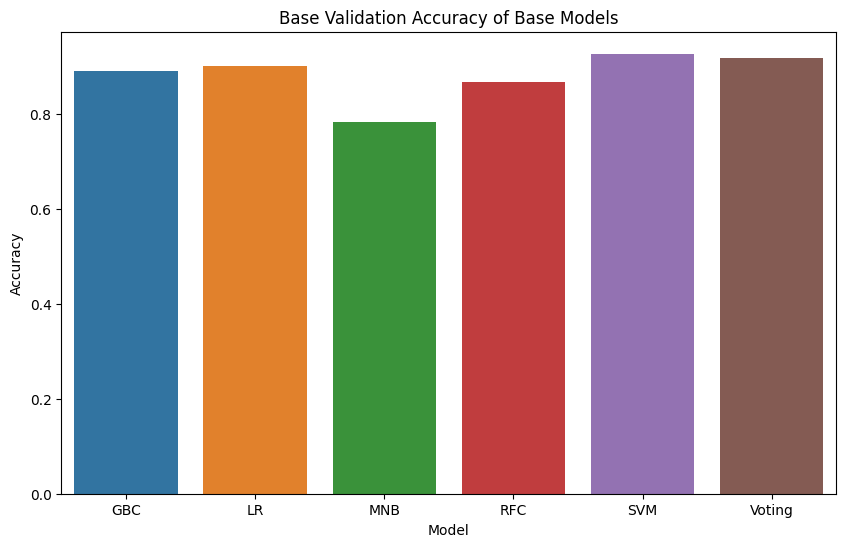

In [25]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=base_valid_res_df)
title='Base Validation Accuracy of Base Models'
plt.title(title)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.savefig(os.path.join(graph_dir,title+'.png'), bbox_inches='tight')
plt.show()
plt.close()

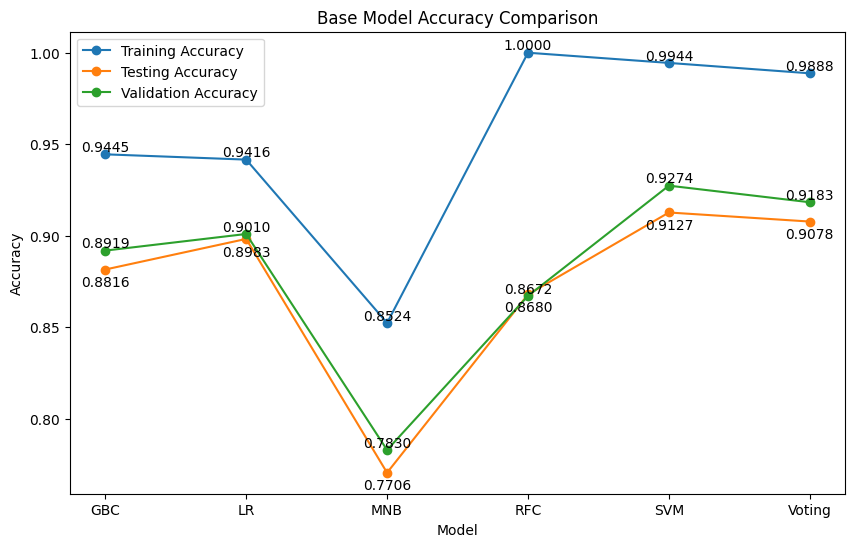

In [26]:
merged_base_df = pd.merge(base_train_res_df, base_test_res_df, on='Model', suffixes=('_train', '_test'))
merged_base_df = pd.merge(merged_base_df, base_valid_res_df, on='Model')

plt.figure(figsize=(10, 6))

plt.plot(merged_base_df['Model'], merged_base_df['Accuracy_train'], marker='o', label='Training Accuracy')
for x, y in zip(merged_base_df['Model'], merged_base_df['Accuracy_train']):
    plt.text(x, y, f'{y:.4f}', ha='center', va='bottom')

plt.plot(merged_base_df['Model'], merged_base_df['Accuracy_test'], marker='o', label='Testing Accuracy')
for x, y in zip(merged_base_df['Model'], merged_base_df['Accuracy_test']):
    plt.text(x, y-0.011, f'{y:.4f}', ha='center', va='bottom')

plt.plot(merged_base_df['Model'], merged_base_df['Accuracy'], marker='o', label='Validation Accuracy')
for x, y in zip(merged_base_df['Model'], merged_base_df['Accuracy']):
    plt.text(x, y, f'{y:.4f}', ha='center', va='bottom')

title = 'Base Model Accuracy Comparison'
plt.title(title)
plt.xlabel('Model')
plt.ylabel('Accuracy')

plt.legend()
plt.savefig(os.path.join(graph_dir,title+'.png'), bbox_inches='tight')
plt.show()
plt.close()

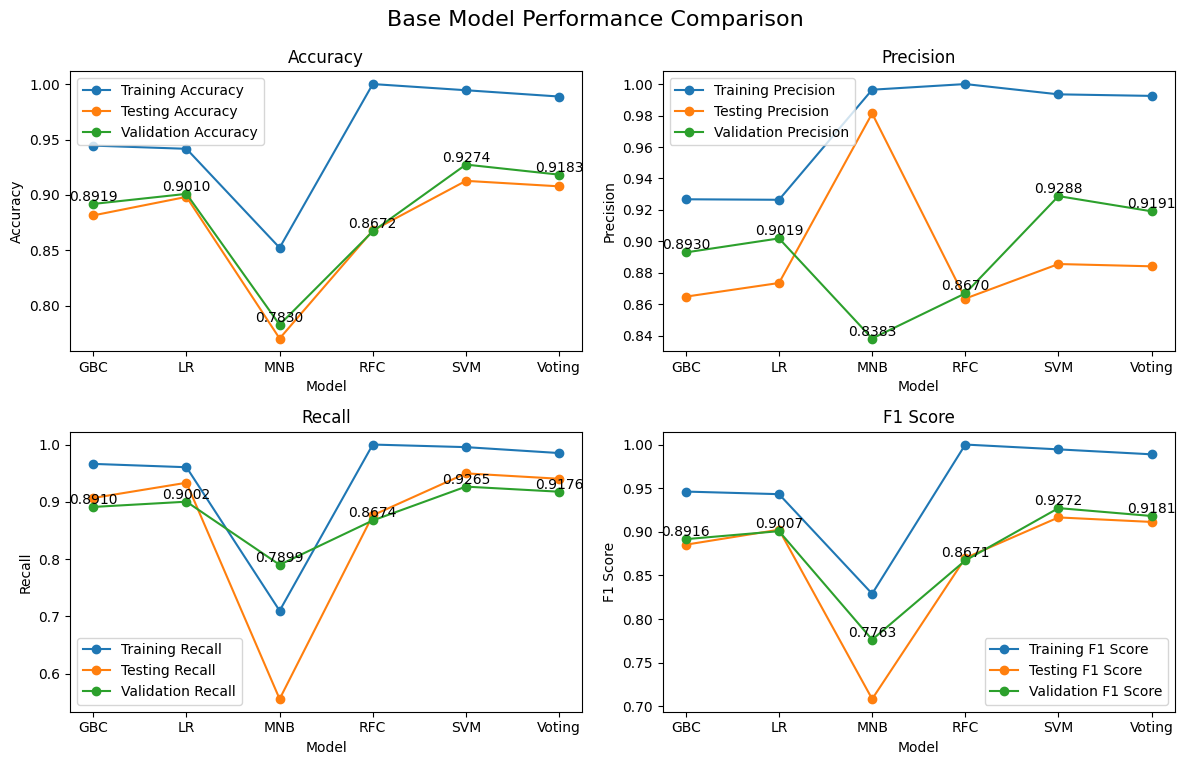

In [27]:
# Create a figure with 2x2 subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Accuracy subgraph
axes[0, 0].plot(merged_base_df['Model'], merged_base_df['Accuracy_train'], marker='o', label='Training Accuracy')
axes[0, 0].plot(merged_base_df['Model'], merged_base_df['Accuracy_test'], marker='o', label='Testing Accuracy')
axes[0, 0].plot(merged_base_df['Model'], merged_base_df['Accuracy'], marker='o', label='Validation Accuracy')
axes[0, 0].set_title('Accuracy')
axes[0, 0].set_xlabel('Model')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
for x, y in zip(merged_base_df['Model'], merged_base_df['Accuracy']):
    axes[0, 0].text(x, y, f'{y:.4f}', ha='center', va='bottom')

# Precision subgraph
axes[0, 1].plot(merged_base_df['Model'], merged_base_df['Precision_train'], marker='o', label='Training Precision')
axes[0, 1].plot(merged_base_df['Model'], merged_base_df['Precision_test'], marker='o', label='Testing Precision')
axes[0, 1].plot(merged_base_df['Model'], merged_base_df['Precision'], marker='o', label='Validation Precision')
axes[0, 1].set_title('Precision')
axes[0, 1].set_xlabel('Model')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].legend()
for x, y in zip(merged_base_df['Model'], merged_base_df['Precision']):
    axes[0, 1].text(x, y, f'{y:.4f}', ha='center', va='bottom')

# Recall subgraph
axes[1, 0].plot(merged_base_df['Model'], merged_base_df['Recall_train'], marker='o', label='Training Recall')
axes[1, 0].plot(merged_base_df['Model'], merged_base_df['Recall_test'], marker='o', label='Testing Recall')
axes[1, 0].plot(merged_base_df['Model'], merged_base_df['Recall'], marker='o', label='Validation Recall')
axes[1, 0].set_title('Recall')
axes[1, 0].set_xlabel('Model')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].legend()
for x, y in zip(merged_base_df['Model'], merged_base_df['Recall']):
    axes[1, 0].text(x, y, f'{y:.4f}', ha='center', va='bottom')

# F1 Score subgraph
axes[1, 1].plot(merged_base_df['Model'], merged_base_df['F1-Score_train'], marker='o', label='Training F1 Score')
axes[1, 1].plot(merged_base_df['Model'], merged_base_df['F1-Score_test'], marker='o', label='Testing F1 Score')
axes[1, 1].plot(merged_base_df['Model'], merged_base_df['F1-Score'], marker='o', label='Validation F1 Score')
axes[1, 1].set_title('F1 Score')
axes[1, 1].set_xlabel('Model')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].legend()
for x, y in zip(merged_base_df['Model'], merged_base_df['F1-Score']):
    axes[1, 1].text(x, y, f'{y:.4f}', ha='center', va='bottom')

# Adjust the spacing between subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save and display the graph
title = 'Base Model Performance Comparison'
plt.suptitle(title, fontsize=16)
plt.savefig(os.path.join(graph_dir, title+'.png'), bbox_inches='tight')
plt.show()
plt.close()

<h3>Hyper Tuned</h3>

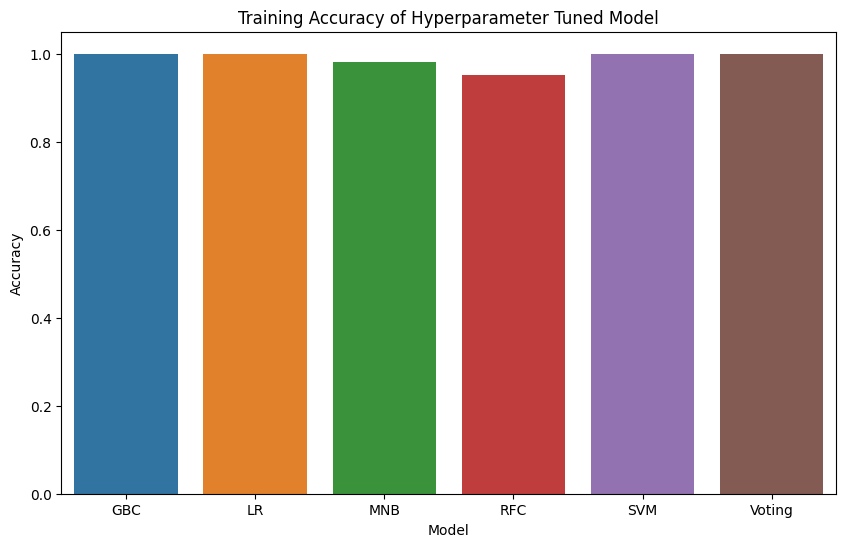

In [28]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=train_res_df)
title='Training Accuracy of Hyperparameter Tuned Model'
plt.title(title)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.savefig(os.path.join(graph_dir,title+'.png'), bbox_inches='tight')
plt.show()
plt.close()

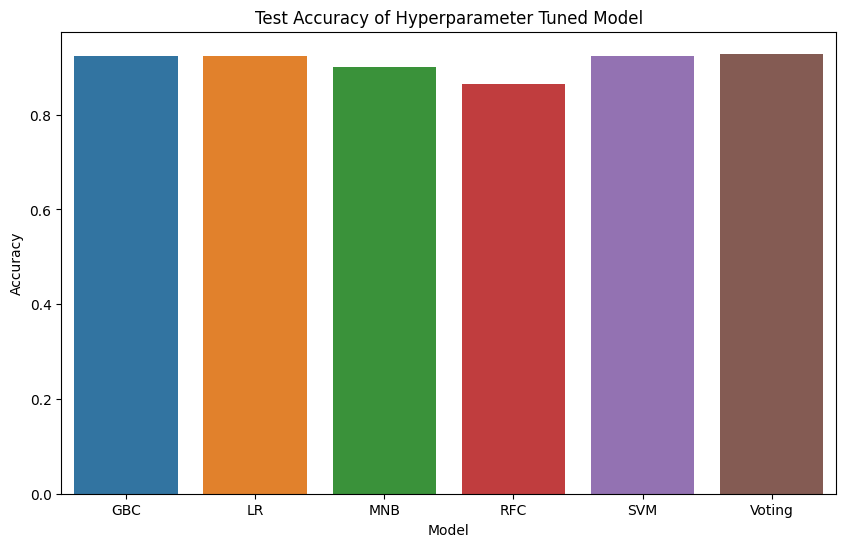

In [29]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=test_res_df)
title = 'Test Accuracy of Hyperparameter Tuned Model'
plt.title(title)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.savefig(os.path.join(graph_dir,title+'.png'), bbox_inches='tight')
plt.show()
plt.close()

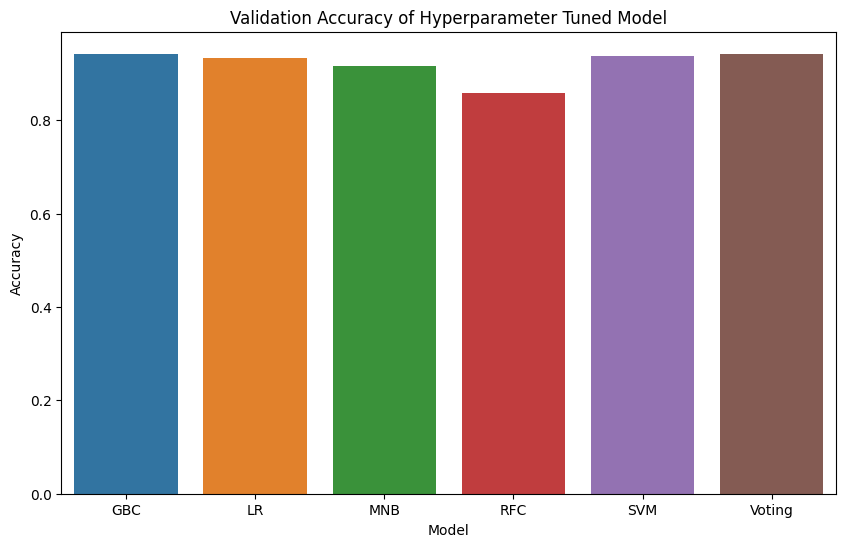

In [30]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=valid_res_df)
title='Validation Accuracy of Hyperparameter Tuned Model'
plt.title(title)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.savefig(os.path.join(graph_dir,title+'.png'), bbox_inches='tight')
plt.show()
plt.close()

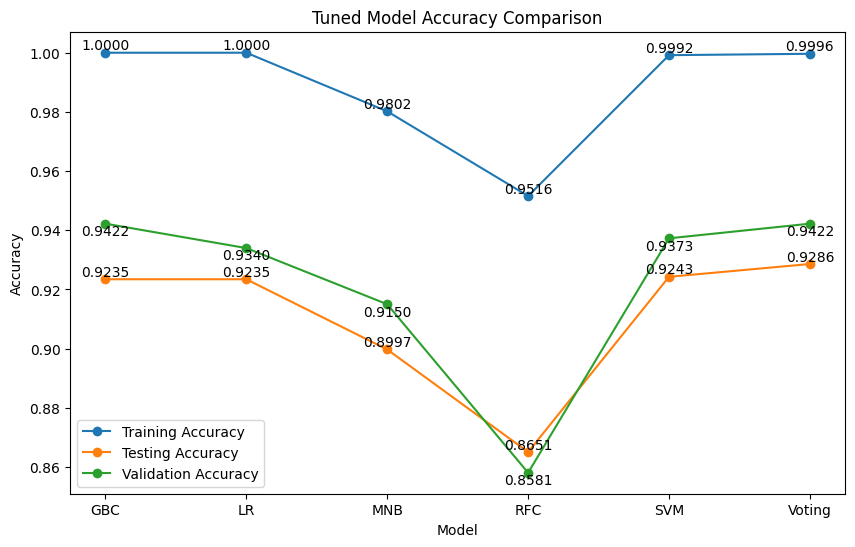

In [31]:
merged_tuned_df = pd.merge(train_res_df, test_res_df, on='Model', suffixes=('_train', '_test'))
merged_tuned_df = pd.merge(merged_tuned_df, valid_res_df, on='Model')

plt.figure(figsize=(10, 6))

plt.plot(merged_tuned_df['Model'], merged_tuned_df['Accuracy_train'], marker='o', label='Training Accuracy')
for x, y in zip(merged_tuned_df['Model'], merged_tuned_df['Accuracy_train']):
    plt.text(x, y, f'{y:.4f}', ha='center', va='bottom')

plt.plot(merged_tuned_df['Model'], merged_tuned_df['Accuracy_test'], marker='o', label='Testing Accuracy')
for x, y in zip(merged_tuned_df['Model'], merged_tuned_df['Accuracy_test']):
    plt.text(x, y, f'{y:.4f}', ha='center', va='bottom')

plt.plot(merged_tuned_df['Model'], merged_tuned_df['Accuracy'], marker='o', label='Validation Accuracy')
for x, y in zip(merged_tuned_df['Model'], merged_tuned_df['Accuracy']):
    plt.text(x, y-0.005, f'{y:.4f}', ha='center', va='bottom')

title='Tuned Model Accuracy Comparison'
plt.title(title)
plt.xlabel('Model')
plt.ylabel('Accuracy')

plt.legend()
plt.savefig(os.path.join(graph_dir,title+'.png'), bbox_inches='tight')
plt.show()
plt.close()

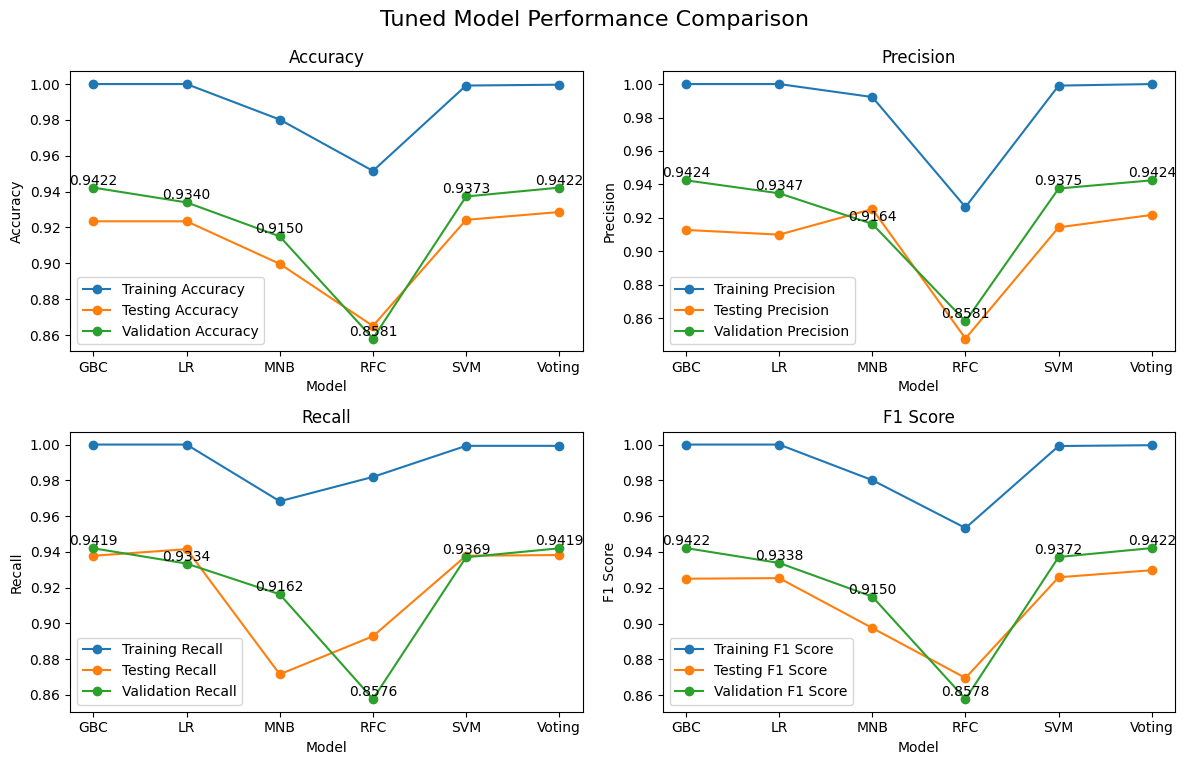

In [32]:
# Create a figure with 2x2 subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Accuracy subgraph
axes[0, 0].plot(merged_tuned_df['Model'], merged_tuned_df['Accuracy_train'], marker='o', label='Training Accuracy')
axes[0, 0].plot(merged_tuned_df['Model'], merged_tuned_df['Accuracy_test'], marker='o', label='Testing Accuracy')
axes[0, 0].plot(merged_tuned_df['Model'], merged_tuned_df['Accuracy'], marker='o', label='Validation Accuracy')
axes[0, 0].set_title('Accuracy')
axes[0, 0].set_xlabel('Model')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
for x, y in zip(merged_tuned_df['Model'], merged_tuned_df['Accuracy']):
    axes[0, 0].text(x, y, f'{y:.4f}', ha='center', va='bottom')

# Precision subgraph
axes[0, 1].plot(merged_tuned_df['Model'], merged_tuned_df['Precision_train'], marker='o', label='Training Precision')
axes[0, 1].plot(merged_tuned_df['Model'], merged_tuned_df['Precision_test'], marker='o', label='Testing Precision')
axes[0, 1].plot(merged_tuned_df['Model'], merged_tuned_df['Precision'], marker='o', label='Validation Precision')
axes[0, 1].set_title('Precision')
axes[0, 1].set_xlabel('Model')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].legend()
for x, y in zip(merged_tuned_df['Model'], merged_tuned_df['Precision']):
    axes[0, 1].text(x, y, f'{y:.4f}', ha='center', va='bottom')

# Recall subgraph
axes[1, 0].plot(merged_tuned_df['Model'], merged_tuned_df['Recall_train'], marker='o', label='Training Recall')
axes[1, 0].plot(merged_tuned_df['Model'], merged_tuned_df['Recall_test'], marker='o', label='Testing Recall')
axes[1, 0].plot(merged_tuned_df['Model'], merged_tuned_df['Recall'], marker='o', label='Validation Recall')
axes[1, 0].set_title('Recall')
axes[1, 0].set_xlabel('Model')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].legend()
for x, y in zip(merged_tuned_df['Model'], merged_tuned_df['Recall']):
    axes[1, 0].text(x, y, f'{y:.4f}', ha='center', va='bottom')

# F1 Score subgraph
axes[1, 1].plot(merged_tuned_df['Model'], merged_tuned_df['F1-Score_train'], marker='o', label='Training F1 Score')
axes[1, 1].plot(merged_tuned_df['Model'], merged_tuned_df['F1-Score_test'], marker='o', label='Testing F1 Score')
axes[1, 1].plot(merged_tuned_df['Model'], merged_tuned_df['F1-Score'], marker='o', label='Validation F1 Score')
axes[1, 1].set_title('F1 Score')
axes[1, 1].set_xlabel('Model')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].legend()
for x, y in zip(merged_tuned_df['Model'], merged_tuned_df['F1-Score']):
    axes[1, 1].text(x, y, f'{y:.4f}', ha='center', va='bottom')

# Adjust the spacing between subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save and display the graph
title = 'Tuned Model Performance Comparison'
plt.suptitle(title, fontsize=16)
plt.savefig(os.path.join(graph_dir, title+'.png'), bbox_inches='tight')
plt.show()
plt.close()

<h3>Others</h3>

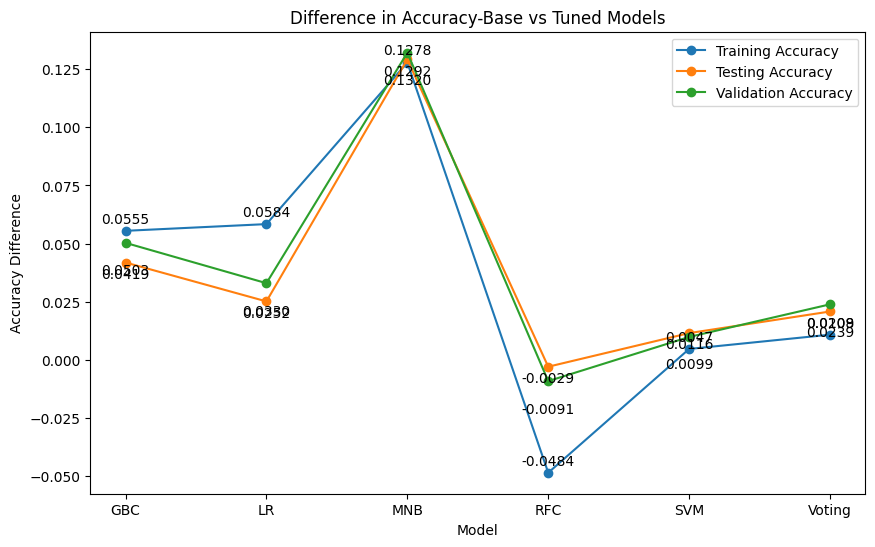

In [33]:
# Calculate the difference in accuracies between base and tuned models
merged_diff_df = pd.DataFrame()
merged_diff_df['Model'] = merged_base_df['Model']
merged_diff_df['Diff_Accuracy_train'] = merged_tuned_df['Accuracy_train'] - merged_base_df['Accuracy_train']
merged_diff_df['Diff_Accuracy_test'] = merged_tuned_df['Accuracy_test'] - merged_base_df['Accuracy_test']
merged_diff_df['Diff_Accuracy'] = merged_tuned_df['Accuracy'] - merged_base_df['Accuracy']

# Plot the difference in accuracies
plt.figure(figsize=(10, 6))

plt.plot(merged_diff_df['Model'], merged_diff_df['Diff_Accuracy_train'], marker='o', label='Training Accuracy')
for x, y in zip(merged_diff_df['Model'], merged_diff_df['Diff_Accuracy_train']):
    plt.text(x, y+0.002, f'{y:.4f}', ha='center', va='bottom')

plt.plot(merged_diff_df['Model'], merged_diff_df['Diff_Accuracy_test'], marker='o', label='Testing Accuracy')
for x, y in zip(merged_diff_df['Model'], merged_diff_df['Diff_Accuracy_test']):
    plt.text(x, y-0.008, f'{y:.4f}', ha='center', va='bottom')

plt.plot(merged_diff_df['Model'], merged_diff_df['Diff_Accuracy'], marker='o', label='Validation Accuracy')
for x, y in zip(merged_diff_df['Model'], merged_diff_df['Diff_Accuracy']):
    plt.text(x, y-0.015, f'{y:.4f}', ha='center', va='bottom')

title = 'Difference in Accuracy-Base vs Tuned Models'
plt.title(title)
plt.xlabel('Model')
plt.ylabel('Accuracy Difference')

plt.legend()
plt.savefig(os.path.join(graph_dir, title+'.png'), bbox_inches='tight')
plt.show()
plt.close()